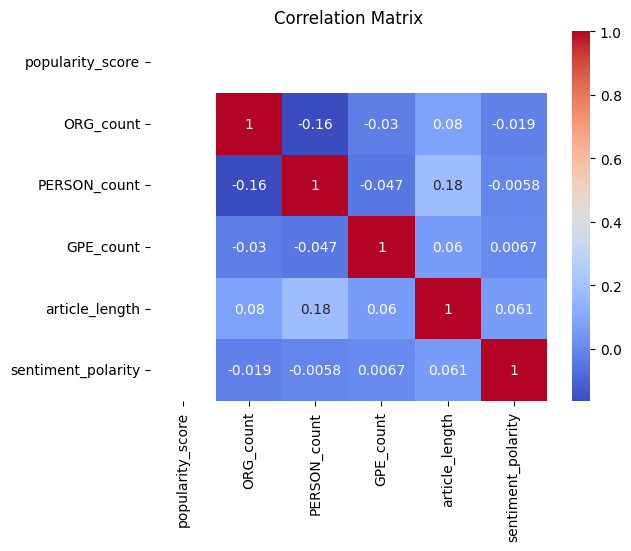

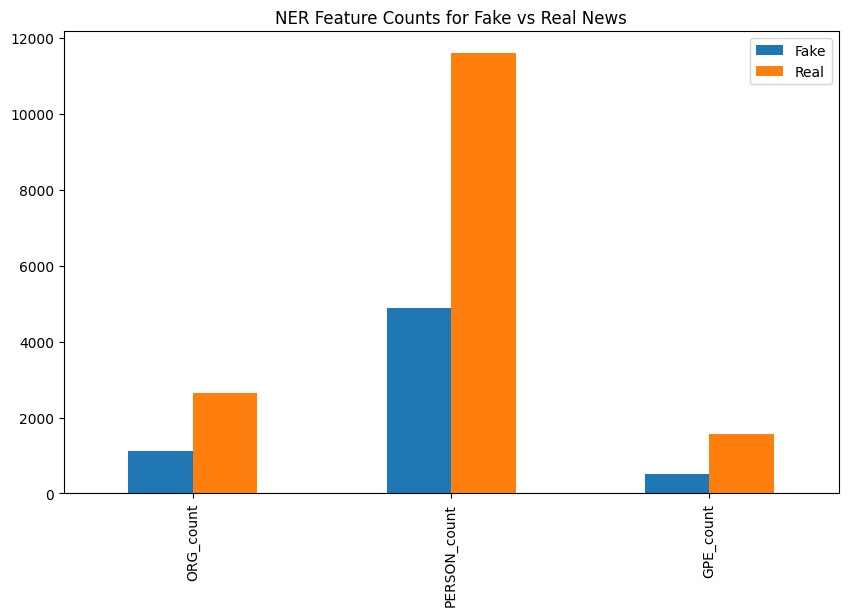

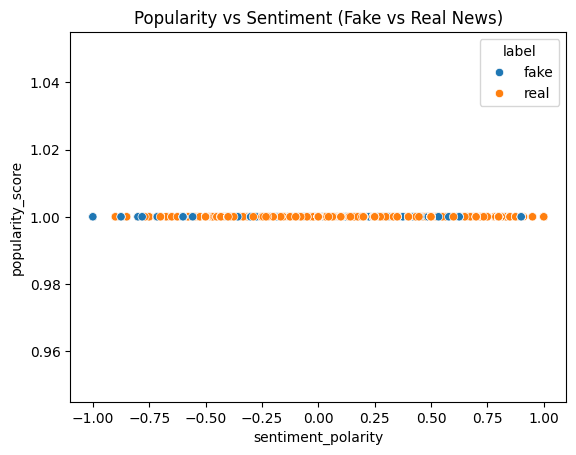

Mean Popularity and Sentiment by Label:
       popularity_score  sentiment_polarity
label                                      
fake                1.0            0.033495
real                1.0            0.085961


In [5]:
import pandas as pd
import spacy
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# Load datasets
gossipcop_fake = pd.read_csv("E:\Deep_Learning\AGT\FakeNewsNet-master\dataset\gossipcop_fake.csv")
gossipcop_real = pd.read_csv("E:\Deep_Learning\AGT\FakeNewsNet-master\dataset\gossipcop_real.csv")
politifact_fake = pd.read_csv("E:\Deep_Learning\AGT\FakeNewsNet-master\dataset\politifact_fake.csv")
politifact_real = pd.read_csv("E:\Deep_Learning\AGT\FakeNewsNet-master\dataset\politifact_real.csv")

# Add 'label' and 'source' columns
gossipcop_fake['label'] = 'fake'
gossipcop_fake['source'] = 'gossipcop'
gossipcop_real['label'] = 'real'
gossipcop_real['source'] = 'gossipcop'
politifact_fake['label'] = 'fake'
politifact_fake['source'] = 'politifact'
politifact_real['label'] = 'real'
politifact_real['source'] = 'politifact'

# Combine datasets
data = pd.concat([gossipcop_fake, gossipcop_real, politifact_fake, politifact_real], ignore_index=True)

# Preprocessing
def preprocess_text(text):
    text = text.lower().strip()
    return text

data['cleaned_title'] = data['title'].apply(preprocess_text)

# Named Entity Recognition (NER)
def extract_ner_features(text):
    doc = nlp(text)
    entities = {"ORG": 0, "PERSON": 0, "GPE": 0}
    for ent in doc.ents:
        if ent.label_ in entities:
            entities[ent.label_] += 1
    return entities

data['ner_features'] = data['cleaned_title'].apply(extract_ner_features)

# Expand NER features into separate columns
data['ORG_count'] = data['ner_features'].apply(lambda x: x['ORG'])
data['PERSON_count'] = data['ner_features'].apply(lambda x: x['PERSON'])
data['GPE_count'] = data['ner_features'].apply(lambda x: x['GPE'])

# Article Length
data['article_length'] = data['cleaned_title'].apply(lambda x: len(x.split()))

# Sentiment Analysis
data['sentiment_polarity'] = data['cleaned_title'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Popularity Score (using tweet_ids as a proxy)
data['popularity_score'] = data['tweet_ids'].apply(lambda x: len(str(x).split(",")))

# Correlation Analysis
correlation_matrix = data[['popularity_score', 'ORG_count', 'PERSON_count', 'GPE_count', 'article_length', 'sentiment_polarity']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Visualizations
# Bar Chart: NER feature counts for fake and real news
ner_counts_fake = data[data['label'] == 'fake'][['ORG_count', 'PERSON_count', 'GPE_count']].sum()
ner_counts_real = data[data['label'] == 'real'][['ORG_count', 'PERSON_count', 'GPE_count']].sum()

ner_counts = pd.DataFrame({'Fake': ner_counts_fake, 'Real': ner_counts_real})
ner_counts.plot(kind="bar", title="NER Feature Counts for Fake vs Real News", figsize=(10, 6))
plt.show()

# Scatter Plot: Popularity vs Sentiment
sns.scatterplot(data=data, x='sentiment_polarity', y='popularity_score', hue='label')
plt.title("Popularity vs Sentiment (Fake vs Real News)")
plt.show()

# Additional Analysis
# Group by Label to Analyze Mean Popularity and Sentiment
summary = data.groupby('label')[['popularity_score', 'sentiment_polarity']].mean()
print("Mean Popularity and Sentiment by Label:")
print(summary)
